<a href="https://colab.research.google.com/github/YadnyeshChakane/fun_with_jax/blob/main/jax_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Syntax of JAX is same as NumPY's (for most part)
# SciPy API Support

import jax.numpy as jnp
import numpy as np
import jax

# Special Transform Functions
from jax import grad, jit, vmap, pmap

# JAX's low level API - lax (anagram for xla) - XLA: Accelerated Linear Algebra
from jax import lax

from jax import make_jaxpr # make_jaxpr is a function in JAX that is used to create a JAX Program Representation (JAXPR) for a given Python function. JAXPR is an internal representation of the computation that can be useful for debugging and introspection.
from jax import random     # The random module is used to generate random numbers using JAX's PRNG (Pseudorandom Number Generator).
from jax import device_put # device_put is used to transfer data to a specific JAX device (such as a GPU or CPU). It is often used to move data to the appropriate device for efficient computation.
import matplotlib.pyplot as plt # This line imports the matplotlib library for data visualization.

In [ ]:
# The most used APIs are the following:

jax.numpy
jax.lax

# While the topics that are very important in the API design paradigm are:

# Just-in-time compilation (jit)
# Automatic differentiation (grad)
# Vectorization (vmap)
# Parallelization (pmap

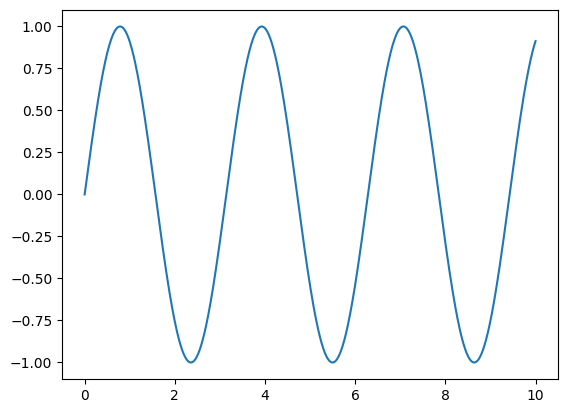

In [ ]:
# Syntax of Numpy

x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np)

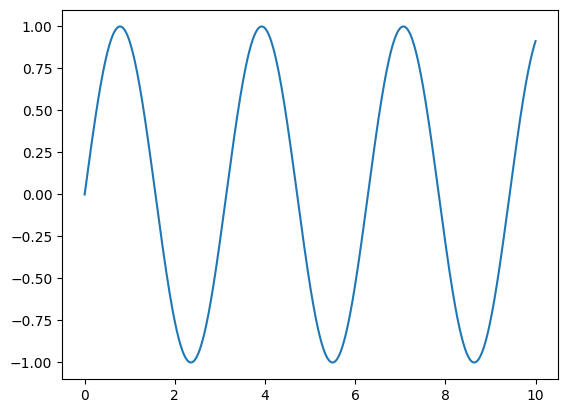

In [ ]:
# Syntax of JAX

x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)



In [ ]:
# JAX arrays are immutable!

size = 10
index = 0
value = 23

# In NumPy arrays are mutable
x = np.arange(size)
print(x)
x[index] = value
print(x)


[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [ ]:
# In JAX we have to deal with immutable arrays
x = jnp.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]


TypeError: ignored

In [ ]:
# Solution:
y = x.at[index].set(value)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [ ]:
# JAX handles random numbers differently (for a good reason! we'll see later why)
seed = 0
key = random.PRNGKey(seed)

x = random.normal(key, (10, ))  # you need to explicitly pass the key i.e. PRNG state
print(type(x), x)  # notice the DeviceArray type - that leads us to the next cell!

<class 'jaxlib.xla_extension.ArrayImpl'> [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [ ]:
# JAX is GPU/TPU agnostic. Same code runs everywhere!

size = 3000

# Data is automatically pushed to the GPU/TPU! (DeviceArray structure)
# No more need for ".to(device)" (PyTorch syntax)
x_jnp = random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)  # some diff in API exists!

%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()  # 1) on GPU - fast
%timeit np.dot(x_np, x_np.T)  # 2) on CPU - slow (NumPy only works with CPUs)
%timeit jnp.dot(x_np, x_np.T).block_until_ready()  # 3) on GPU with transfer overhead

x_np_device = device_put(x_np)  # push NumPy explicitly to GPU
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()  # same as 1)

# Note: block_until_ready() -> asynchronous dispatch

15.1 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
333 ms ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
44.1 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.4 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


***JAX Transform Functions -***
In JAX, the **jax.vmap**, **jax.jit**, and **jax.grad** functions are essential for transforming and optimizing your code for automatic differentiation and high-performance numerical computing.

* jit() - just in time - compiles your functions using XLA and caches them








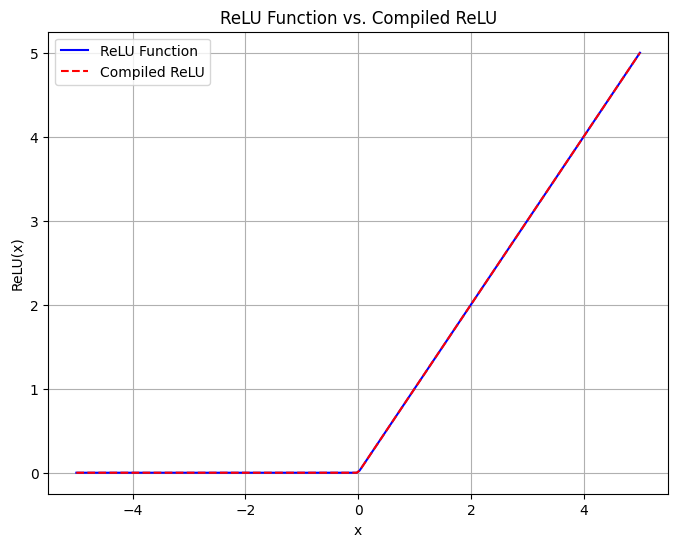

In [ ]:
# Example - Using 'jit()' to compile a ReLU function

# Define the ReLU function
def relu(x):
    return jnp.maximum(0, x)

# Compile the ReLU function using jit()
compiled_relu = jax.jit(relu)

# Generate x values for visualization
x = np.linspace(-5, 5, 200)  # Create an array of 200 points from -5 to 5 using NumPy

# Apply the original ReLU function to x
y_relu = relu(x)

# Apply the compiled ReLU function to x
y_compiled_relu = compiled_relu(x)

# Create a plot to visualize the ReLU and compiled ReLU functions
plt.figure(figsize=(8, 6))
plt.plot(x, y_relu, label='ReLU Function', color='b')
plt.plot(x, y_compiled_relu, label='Compiled ReLU', linestyle='--', color='r')
plt.title('ReLU Function vs. Compiled ReLU')
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.grid()
plt.legend()
plt.show()



* **grad()**

we can compute the gradients (derivatives) of an equation in the following ways:

* **Manual**: We use our calculus knowledge and derive the derivatives by hand. The problem with this approach is that it is manual. It would take a lot of time for a Deep Learning researcher to derive the model’s derivatives by hand.

* **Symbolic**: We can obtain the derivatives via symbols and a program that can mimic the manual process. The problem with this approach is termed expression swell. Here the derivatives of a particular expression are exponentially longer (think chain rule) than the expression itself. This becomes quite difficult to track.

*   **Numeric**: Here, we use the finite differences method to derive the derivatives.

*  **Automatic**:It allows the automatic and efficient computation of gradients or derivatives of functions, making it a fundamental tool in gradient-based optimization and machine learning algorithms.

Automatic differentiation in JAX is at the core of its functionality and enables efficient gradient computation for machine learning and scientific computing. JAX uses a system called "reverse-mode autodiff," which is also known as backpropagation. Here's how automatic differentiation works in JAX:

**Primitives**: JAX provides a set of primitive operations that can be used to define your mathematical functions. These primitives are operations like addition, multiplication, exponentiation, and trigonometric functions. When you write code using these primitives, JAX records the operations in a computation graph.

**Computation Graph**: As you execute operations using JAX's primitives, JAX records these operations in a computation graph (also known as a tape). This graph captures the sequence of operations and their inputs. The computation graph is a directed acyclic graph (DAG) that represents the flow of data in your program.

**Tangent Vectors**: JAX introduces the concept of "tangent vectors." When you apply a gradient operator to a function, it computes the tangent vector (partial derivative) of that function with respect to its inputs. This tangent vector is essentially the gradient.

**Reverse-Mode Autodiff**: Reverse-mode autodiff (also called backpropagation) is the process of computing gradients in a reverse pass through the computation graph. It starts from the output of your function and works its way backward through the graph to compute the gradients with respect to the inputs.

**JVP and VJP**: JAX defines two key functions for automatic differentiation: jax.jvp (Jacobian-vector product) and jax.vjp (vector-Jacobian product). JVP is used for forward-mode autodiff, which is not commonly used in JAX. VJP, on the other hand, is used for reverse-mode autodiff and is the workhorse for gradient computation.

grad Function: The grad function in JAX is a higher-order function that takes a Python function and returns a new Python function that computes the gradient of the original function. This is where JAX's reverse-mode autodiff is applied.









In [ ]:
# First example (automatic diff)

def sum_logistic(x):  # or maybe a simpler example: sum of squares? (jnp.sum(x**2))
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x = jnp.arange(3.)
loss = sum_logistic  # rename it to give it some semantics

# By default grad calculates the derivative of a fn w.r.t. 1st parameter!
# Here we bundled inputs into a 1st param so it doesn't matter.
grad_loss = grad(loss)

print(grad_loss(x))

[0.25       0.19661194 0.10499357]


In [ ]:
# Numeric diff (to double check that autodiff works correctly)

def finite_differences(f, x):
    eps = 1e-3
    # f(0+e, 1, 2) - f(0-e, 1, 2) / 2e
    return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)  # derivative definition
                                for v in jnp.eye(len(x))])

print(finite_differences(loss, x))

[0.24998187 0.1965761  0.10502338]


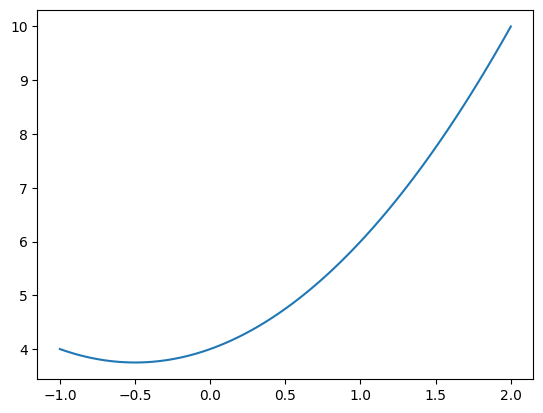

6.0 3.0 2.0 0.0


In [ ]:
# Second example (automatic diff)

# Simple helper visualization function
def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, num=n)
    y = fn(x)
    plt.plot(x, y); plt.show()

x = 1.  # example input

f = lambda x: x**2 + x + 4  # simple 2nd order polynomial fn
visualize_fn(f, l=-1, r=2, n=100)

dfdx = grad(f)  # 2*x + 1
d2fdx = grad(dfdx)  # 2
d3fdx = grad(d2fdx)  # 0

print(f(x), dfdx(x), d2fdx(x), d3fdx(x))

# Task: what if we had 2 inputs?

# Note1: Closer to math!
# Note2: More powerful compared to .backward() (PyTorch syntax)

In [ ]:
# JAX autodiff engine is very powerful ("advanced" example)

from jax import jacfwd, jacrev

# jacfwd (Forward-Mode Jacobian):
# This function computes the Jacobian matrix using forward-mode automatic differentiation. It is primarily used when you have a function with multiple inputs and a single output (i.e., a vector-to-scalar function).
# jacrev (Reverse-Mode Jacobian): jacrev computes the Jacobian matrix using reverse-mode automatic differentiation, which is well-suited for functions with many inputs and a single output (i.e., a vector-to-scalar function). Commonly used in DL frameworks for backpropagation.
f = lambda x, y: x**2 + y**2  # simple paraboloid (google it...)

# df/dx = 2x
# df/dy = 2y
# J = [df/dx, df/dy]

# d2f/dx = 2
# d2f/dy = 2
# d2f/dxdy = 0
# d2f/dydx = 0
# H = [[d2f/dx, d2f/dxdy], [d2f/dydx, d2f/dy]]

def hessian(f):
    return jit(jacfwd(jacrev(f, argnums=(0, 1)), argnums =(0, 1)))

print(f'Jacobian = {jacrev(f, argnums=(0, 1))(1., 1.)}')
print(f'Full Hessian = {hessian(f)(1., 1.)}')

Jacobian = (Array(2., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True))
Full Hessian = ((Array(2., dtype=float32, weak_type=True), Array(0., dtype=float32, weak_type=True)), (Array(0., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True)))


**vmap()**

vmap() is a fundamental function provided by JAX for vectorization. It enables you to apply a function element-wise to arrays or sequences without explicit for loops. This is especially valuable in machine learning and scientific computing, where operations often need to be applied to multiple data points in parallel.
Write your functions as if you were dealing with a single datapoint!


In [ ]:
W = random.normal(key, (150, 100))  # e.g. weights of a linear NN layer
batched_x = random.normal(key, (10, 100))  # e.g. a batch of 10 flattened images

def apply_matrix(x):
    return jnp.dot(W, x)  # (150, 100) * (100, 1) -> (150, 1)

In [ ]:
def naively_batched_apply_matrix(batched_x):
    return jnp.stack([apply_matrix(x) for x in batched_x])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
5.96 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, W.T)  # (10, 100) * (100, 150) -> (10, 150)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
181 µs ± 28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
@jit  # Note: we can arbitrarily compose JAX transforms! Here jit + vmap.
def vmap_batched_apply_matrix(batched_x):
    return vmap(apply_matrix)(batched_x)

# Task: modify apply_matrix to have 2 inputs and use in_axes arg

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
154 µs ± 51.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
